<center> <font size=8.5>房价预测实战 Hackathon <font> </center>

<p align="right" style="line-height: 1;"> <font size=4.7>  财政金融学院 王晨曦 2022200147   <br> 2024年12月26日 </font>  </p>


## Section 0: 导入必要的库

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import re
import jieba
import jieba.posseg as pseg
import cn2an
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
import geopy
from geopy.distance import geodesic
from joblib import Parallel, delayed
from collections import defaultdict
import chardet
import csv
import dask.dataframe as dd
import dask.config
from dask import delayed, compute
from rtree import index
from tqdm import tqdm


import xgboost as xgb
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import optuna

import warnings
# 屏蔽所有警告
warnings.filterwarnings("ignore")

import logging
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

# 设置Dask客户端，以便更好地控制内存使用
from dask.distributed import Client
client = Client(memory_limit='20GB')  # 请依据实际内存大小调整

# Dask自动管理内存使用
dask.config.set({
    'distributed.worker.memory.target': 'auto',
    'distributed.worker.memory.spill': 'auto',
    'distributed.worker.memory.pause': 'auto',
    'distributed.worker.memory.limit': 'auto',
    'distributed.scheduler.work-stealing': True,
})

# 配置matplotlib中文字体
rcParams['font.sans-serif'] = ['SimHei']  # 或者使用 'Microsoft YaHei'
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

## Section 1: 数据处理

### 1.1 POI数据处理

#### 1.1.1 读取相关POI点的是数据，并看形状

In [ ]:
poi_bingcheng = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\哈尔滨市POI数据.csv", usecols=['大类', '中类', '经度', '纬度'])
poi_jinji = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\廊坊市POI数据.csv", usecols=['大类', '中类', '经度', '纬度'])
poi_jinmen = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\天津市POI数据.csv", usecols=['大类', '中类', '经度', '纬度'])
poi_jiangcheng = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\武汉市POI数据.csv", usecols=['大类', '中类', '经度', '纬度'])
poi_changan = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\西安市POI数据.csv", usecols=['大类', '中类', '经度', '纬度'])
poi_tianfu = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\重庆市POI数据.csv", usecols=['大类', '中类', '经度', '纬度'])

print(poi_bingcheng.shape)
print(poi_jinji.shape)
print(poi_jinmen.shape)
print(poi_jiangcheng.shape)
print(poi_changan.shape)
print(poi_tianfu.shape)

poi_df = pd.concat([poi_bingcheng, poi_jinji, poi_jinmen, poi_jiangcheng, poi_changan, poi_tianfu])
print(poi_df.shape)
print(poi_df.head())
# poi_bingcheng.to_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\c_poi哈尔滨市POI数据.csv", encoding='utf-8-sig')
# poi_jinji.to_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\c_poi廊坊市POI数据.csv", encoding='utf-8-sig')
# poi_jinmen.to_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\c_poi天津市POI数据.csv", encoding='utf-8-sig')
# poi_jiangcheng.to_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\c_poi武汉市POI数据.csv", encoding='utf-8-sig')
# poi_changan.to_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\c_poi西安市POI数据.csv", encoding='utf-8-sig')
# poi_tianfu.to_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\poi\\c_poi重庆市POI数据.csv", encoding='utf-8-sig')

# 清理POI数据中的无效经纬度
poi_df = poi_df[(poi_df['纬度'] >= -90) & (poi_df['纬度'] <= 90) & (poi_df['经度'] >= -180) & (poi_df['经度'] <= 180)]

print(poi_df.shape)

(250042, 4)
(172491, 4)
(409020, 4)
(430653, 4)
(398638, 4)
(892261, 4)
(2553105, 4)
     大类  中类          经度         纬度
0  旅游景点  景点  127.993749  44.202294
1  生活服务  公厕  128.063668  44.208748
2  生活服务  公厕  128.077060  44.200905
3  生活服务  公厕  128.036828  44.106946
4  生活服务  公厕  128.046635  44.105426
(2553105, 4)


In [ ]:
print(poi_df['大类'].unique())
print(poi_df['中类'].unique())
print(len(poi_df['中类'].unique()))

['旅游景点' '生活服务' '休闲娱乐' '交通设施' '汽车相关' '酒店住宿' '餐饮美食' '商务住宅' '运动健身' '购物消费'
 '医疗保健' '公司企业' '科教文化' '金融机构']
['景点' '公厕' '其他' '停车场' '加油站' '公园' '四星级酒店' '三星级酒店' '旅馆' '中国菜' '诊所' '便利店'
 '超市' '汽车维修' '农林牧渔' '信息咨询中心' '植物园' '住宅区' '图书馆' '家电数码' '幼儿园' '物流' '邮局'
 '摄影打印' '市场' '银行' '医药销售' '小吃快餐' '其他能源站' '文体用品' '家居建材' 'ATM' '美容理发' '公司'
 '洗衣' '洗车' '产业园' '综合医院' '农家乐' '酒吧' '保险' '中学' '洗浴推拿' '电讯营业厅' '彩票销售' '花鸟鱼虫'
 '专科医院' '蛋糕甜品店' '汽车配件' '汽车养护' '服务区' '火车' 'KTV' '小学' '疾病预防' '水族馆' '工厂'
 '别墅区' '冰雪运动' '长途汽车' '台球' '剧场' '度假养老' '青旅' '经济型连锁酒店' '商业街' '游乐场' '水上运动'
 '广场' '外国菜' '培训单位' '汽车租赁' '二手车' '科研单位' '纪念馆' '购物中心' '收费站' '公共事业' '港口码头'
 '宗教' '公交站' '咖啡' '中介' '文化宫' '会展展览' '驾校' '动物医疗' '百货商场' '艺术团体' '露营地' '轮渡'
 '成人教育' '职业技术教育' '汽车销售' '网吧' '动物园' '广播电视' '宿舍' '博物馆' '写字楼' '充电站' '商住两用楼宇'
 '美术展览' '高等教育' '跆拳道' '游泳' '综合体育馆' '加气站' '急救中心' '电影院' '健身中心' '篮球' '茶座'
 '五星级酒店' '科技馆' '足球' '马术&赛马' '棋牌室' '地铁' '高尔夫球' '免税店' '社区中心' '飞机' '乒乓球'
 '投资理财' '羽毛球' '网球' '工业大楼' '档案馆' '新闻出版' '户外健身场所' '天文馆' '红色旅游' '保龄球' '壁球'
 '世界遗产']
136


#### 1.1.2 读取details中的数据

In [ ]:
df_details = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\ruc_Class24Q2_details.csv")
# print(df_details.head().T)
df_details.rename(columns={'coord_y': 'lat', 'coord_x': 'lon'}, inplace=True)

In [ ]:
print(df_details['城市'].value_counts().sum())

2665


#### 1.1.3 POI信息获取——单核运算

In [ ]:
def preprocess_poi_by_city(poi_df, city_column, category_column):
    """
    将 POI 数据按城市分组，并按照类别分组以便加速后续计算。
    """
    poi_dict = defaultdict(lambda: defaultdict(list))
    for _, row in poi_df.iterrows():
        city = row[city_column]
        category = row[category_column]
        poi_dict[city][category].append((row['纬度'], row['经度']))
    return poi_dict

def calculate_category_features(df, poi_dict, category_column, distance_threshold=3):
    """
    对每个数据点，计算其周围 POI 的数量和最小距离。
    """
    # 结果容器
    results = defaultdict(list)
    categories = list(next(iter(poi_dict.values())).keys())  # 获取所有类别
    
    for index, row in df.iterrows():
        city = row['城市']
        lat, lon = row['lat'], row['lon']
        
        if city not in poi_dict:
            print(f"城市 {city} 的 POI 数据不存在，跳过...")
            for category in categories:
                results[f'{category}_count'].append(0)
                results[f'{category}_mini_distance'].append(None)
            continue
        
        city_poi = poi_dict[city]
        for category in categories:
            if category not in city_poi:
                # 如果当前类别的 POI 不存在，填充默认值
                results[f'{category}_count'].append(0)
                results[f'{category}_mini_distance'].append(None)
                continue
            
            poi_list = city_poi[category]
            count = 0
            mini_distance = float('inf')
            
            for poi_lat, poi_lon in poi_list:
                # 计算地理距离
                distance = geodesic((lat, lon), (poi_lat, poi_lon)).km
                if distance < distance_threshold:
                    count += 1
                if distance < mini_distance:
                    mini_distance = distance
            
            results[f'{category}_count'].append(count)
            results[f'{category}_mini_distance'].append(mini_distance)
        
        # 打印日志（可选）
        print(f"城市：{city}, 类别统计完成：{categories}")

    # 将结果添加到 df
    for col, values in results.items():
        df[col] = values

def add_poi_category_counts_optimized(df, poi_df, city_column, category_column, distance_threshold=3):
    """
    整合主函数：处理 POI 数据并计算特征。
    """
    # 预处理 POI 数据（按城市和类别分组）
    poi_dict = preprocess_poi_by_city(poi_df, city_column, category_column)
    
    # 计算特征
    calculate_category_features(df, poi_dict, category_column, distance_threshold)

# 调用函数
add_poi_category_counts_optimized(df_details, poi_df, city_column='城市', category_column='大类', distance_threshold=3)

# 输出结果
print(df_details.head())

df_details.to_csv('df_details_with_poi_features.csv', index=False)


# 上面代码尽量不要实地运行


#### 1.1.4 POI信息获取——并行运算

In [ ]:
# 定义处理函数
def process_category(row, poi_df, category, distance_threshold):
    mini_distance = 10000
    count_category = 0
    for poi_index, poi_row in poi_df.iterrows():
        if poi_row['中类'] == category:
            distances = geodesic((row['lat'], row['lon']), (poi_row['纬度'], poi_row['经度'])).km
            if distances < mini_distance:
                mini_distance = distances
                print(distances, category)
            if distances < distance_threshold:
                count_category += 1

    print(count_category, mini_distance)
    return count_category, mini_distance

# 定义处理函数
def add_poi_category_counts(df, poi_df_dict, category_column, distance_threshold=3):
    # 获取所有类别
    all_categories = poi_df['中类'].unique()
    # for city_poi_df in poi_df_dict.values():
    #     all_categories.extend(city_poi_df[category_column].unique())
    # all_categories = list(set(all_categories))  # 去重

    # 对于每个POI类别，添加一个新列来存储计数
    results = {category: {'counts': [], 'mini_distances': []} for category in all_categories}
    
    # 使用joblib进行并行处理
    tasks = (
        delayed(process_category)(
            row, poi_df_dict[row['城市']], category, distance_threshold
        )
        for index, row in df.iterrows()
        for category in all_categories
    )
    
    results_list = Parallel(n_jobs=-1)(tasks)
    
    # 将结果合并回df
    result_index = 0
    for index, row in df.iterrows():
        for category in all_categories:
            print(category)
            count_category, mini_distance = results_list[result_index]
            results[category]['counts'].append(count_category)
            results[category]['mini_distances'].append(mini_distance)
            result_index += 1
    
    for category, data in results.items():
        df[f'{category}_count'] = data['counts']
        df[f'{category}_mini_distance'] = data['mini_distances']

# 处理预测数据
add_poi_category_counts(df_details, {
    '冰城': poi_bingcheng,
    '江城': poi_jiangcheng,
    '津门市': poi_jinmen,
    '近畿市': poi_jinji,
    '天府市': poi_tianfu,
    '长安': poi_changan
}, '中类')

print(df_details.head())

In [ ]:
df_details.to_csv('df_details_with_poi_features.csv', encoding = 'utf-8-sig')

#### 1.1.5 2018-pku-POI代码实现

该数据集共65,271,054条POI数据


注意：我们最终并没有选择这个数据集

In [ ]:
# 所有文件、完整地址获取
folder_path = '/home/mw/input/POI3361'    # 这边没有修改地址，用的是人大云的地址（实际更改地址即可）
# 获取文件夹下的所有文件和文件夹名
all_files = os.listdir(folder_path)

# # 初始化一个空的DataFrame
# poi_df = pd.DataFrame()
# poi_num = 0

csv_files = []
for f in all_files:
    entire_path = os.path.join(folder_path, f)
    print(entire_path)
    
    csv_files.append(entire_path)

In [ ]:
# POI数据集的数据清洗工作
# 使用blocksize的块来读取CSV文件
ddf = dd.read_csv(csv_files, encoding='gbk', quoting=csv.QUOTE_NONE, usecols=['type', 'location'],
                  blocksize='2000MB')
print("初始数据：")
print(ddf.shape) # 查看形状（不需要调用compute，因为shape已经是一个元组） 
# 计算行数 
print("数据行数：", ddf.shape[0].compute()) # 调用compute计算行数
print(ddf.head())

def dropna_partition(partition):
    return partition.dropna(subset=['type', 'location'])

# 应用dropna_partition函数并输出中间结果
ddf_dropped = ddf.map_partitions(dropna_partition, meta=ddf)
print("删除缺失值后的数据：")
print(ddf_dropped.shape)  # 查看删除缺失值后的数据量
print("数据行数：", ddf_dropped.shape[0].compute()) # 调用compute计算行数
print(ddf_dropped.head())

def extract_first_type(partition):
    partition['type'] = partition['type'].str.split(';').str[0]
    return partition

# 应用extract_first_type函数并输出中间结果
ddf_extracted = ddf_dropped.map_partitions(extract_first_type, meta=ddf_dropped)
print("提取type列中的第一部分内容后的数据：")
print(ddf_extracted.shape)  # 查看提取type列后的数据量
print("数据行数：", ddf_extracted.shape[0].compute()) # 调用compute计算行数
print(ddf_extracted.head())

# 去除type列的空值并输出中间结果
ddf_extracted = ddf_extracted.dropna(subset=['type'])
print("去除type列中的空值后的数据：")
print("数据行数：", ddf_extracted.shape[0].compute())  # 查看去除type列空值后的数据量
print(ddf_extracted.head())

# 将type列转换为分类类型并输出中间结果
ddf_extracted['type'] = ddf_extracted['type'].astype('category')
print("将type列转换为分类类型后的数据：")
print(ddf_extracted.head())

# 分割location列并创建lon和lat列，输出中间结果
ddf_extracted['lon'] = ddf_extracted['location'].str.split('，', n=1, expand=True)[0].astype(float)
ddf_extracted['lat'] = ddf_extracted['location'].str.split('，', n=1, expand=True)[1].astype(float)
ddf_extracted = ddf_extracted.drop(columns=['location'])
print("分割location列并创建lon和lat列后的数据：")
print(ddf_extracted.head())

# 确保所有类别都是已知的，并使用cat.codes将类别变量转换为数值表示
ddf_extracted['type'] = ddf_extracted['type'].cat.as_known()
ddf_extracted['type_code'] = ddf_extracted['type'].cat.codes
print("将type列转换为数值表示后的数据：")
print(ddf_extracted.head())
print("数据行数：", ddf_extracted.shape[0].compute())  # 查看去除type列空值后的数据量

# 计算类别与数值之间的对应关系并打印映射
type_unique = ddf_extracted['type'].unique().compute()
type_codes = ddf_extracted['type'].cat.codes.unique().compute()
type_mapping = dict(zip(type_unique, type_codes))
print("类别与数值之间的对应关系：")
print(type_mapping)

# 打印映射关系和编码后的DataFrame头部
if ddf_extracted.npartitions > 0:
    print("编码后的DataFrame头部：")
    print(ddf_extracted.compute().head())

In [ ]:
# 只保留编码后的type列和lon、lat列
ddf_result = ddf_extracted[['type_code', 'lon', 'lat']]

print("数据行数：", ddf_result.shape[0].compute())  # 查看去除type列空值后的数据量

这里利用了编码来减小内存的使用，讲str转化为int，也可以使用独热编码。

In [ ]:
# 去除无效数据
ddf = ddf_result.dropna(subset=['lon', 'lat'])

# 构建空间索引
def build_spatial_index(df, buffer=0.001):
    spatial_idx = index.Index()
    for i, row in df.iterrows():
        min_lon, min_lat = row['lon'] - buffer, row['lat'] - buffer
        max_lon, max_lat = row['lon'] + buffer, row['lat'] + buffer

        # 检查边界框是否有效
        if min_lon > max_lon or min_lat > max_lat:
            print(f"Skipping invalid bounding box for row {i}: min_lon={min_lon}, max_lon={max_lon}, min_lat={min_lat}, max_lat={max_lat}")
            continue
        
        spatial_idx.insert(i, (min_lon, min_lat, max_lon, max_lat))
    return spatial_idx


# 获取附近点
def get_nearby_points(lon, lat, spatial_idx, ddf, max_distance_km):
    min_lon, min_lat = lon - 0.001, lat - 0.001
    max_lon, max_lat = lon + 0.001, lat + 0.001
    nearby_indices = list(spatial_idx.intersection((min_lon, min_lat, max_lon, max_lat), objects=False))
    nearby_points = ddf.iloc[nearby_indices]

    # 如果附近没有点，计算全局最小距离
    if len(nearby_points) == 0:
        # 计算所有点的距离
        all_points_coords = ddf[['lat', 'lon']].to_numpy()
        distances = np.array([geodesic((lat, lon), (lat2, lon2)).km for lat2, lon2 in all_points_coords])
        
        # 获取最小距离点及索引
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        
        # 返回最小点信息
        nearest_point = ddf.iloc[min_index:min_index+1]  # 保持 DataFrame 格式
        distances_series = pd.Series([min_distance], index=nearest_point.index)
        return nearest_point, distances_series

    # 矢量化计算地理距离
    points_coords = nearby_points[['lat', 'lon']].to_numpy()
    distances = np.array([geodesic((lat, lon), (lat2, lon2)).km for lat2, lon2 in points_coords])

    # 将距离与 nearby_points 的索引对齐
    distances_series = pd.Series(distances, index=nearby_points.index)
    return nearby_points, distances_series

# 计算类型计数和最近距离
def compute_type_counts_and_distances(nearby_points, distances):
    type_counts = {i: 0 for i in range(23)}
    min_distances = {i: np.nan for i in range(23)}

    for index, row in nearby_points.iterrows():
        type_code = row['type_code']
        distance = distances.loc[index]
        type_counts[type_code] += 1
        if np.isnan(min_distances[type_code]) or distance < min_distances[type_code]:
            min_distances[type_code] = distance

    return type_counts, min_distances

# 主函数：添加附近类型计数和最近距离
def add_nearby_type_counts_and_nearest_distances(df_cleaned, ddf, max_distance_km=3):
    ddf_pandas = ddf.compute()
    print("Converted Dask DataFrame to Pandas DataFrame.")
    spatial_idx = build_spatial_index(ddf_pandas)
    print("Spatial index built successfully.")

    tqdm_iter = tqdm(df_cleaned.iterrows(), total=len(df_cleaned), desc="Processing rows")

    columns = ['type' + str(i) for i in range(23)] + ['nearest_type_' + str(i) for i in range(23)]

    def process_row(row):
        lon, lat = row['lon'], row['lat']
        nearby_points, distances = get_nearby_points(lon, lat, spatial_idx, ddf_pandas, max_distance_km)
        
        if nearby_points.empty:
            # 如果未找到点，get_nearby_points 会直接返回全局最近点
            return pd.Series([0] * 23 + [np.nan] * 23, index=columns)

        # 计算类型计数和最短距离
        type_counts, min_distances = compute_type_counts_and_distances(nearby_points, distances)
        return pd.Series(
            [type_counts[i] for i in range(23)] + [min_distances[i] for i in range(23)],
            index=columns
        )

    results = pd.DataFrame(
        [process_row(row) for _, row in tqdm_iter],
        columns=columns,
        index=df_cleaned.index
    )
    
    df_cleaned = pd.concat([df_cleaned, results], axis=1)
    return df_cleaned

# 调用函数并保存结果
df_details_with_types_and_distances = add_nearby_type_counts_and_nearest_distances(df_details, ddf, max_distance_km=3)

### 1.2 数据清洗工作——与期中相差不大

In [30]:
df_ori = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\ruc_Class24Q2_train.csv")
df_ori.head().T
df_pre = pd.read_csv("E:\\大三上学科\\AI与Python\\Exam\\Final-Exam\\data\\ruc_Class24Q2_test.csv")
df_pre.head().T

,Unnamed: 0,ID,城市,区域,板块,环线,小区名称,房屋户型,所在楼层,建筑面积,...,抵押信息,房屋优势,核心卖点,户型介绍,周边配套,交通出行,lon,lat,年份,价格_fake
0,0,0,近畿市,86.0,503.0,NaN,珠光逸景,1室1厅1厨1卫,中楼层 (共29层),65.46㎡,...,NaN,、房本满两年,本房是南向一居室，采光无遮挡，小区环境优美,本房房龄新，进门是客厅，客厅和卧室全朝南，很大的增加了房的采光,NaN,NaN,116.978107,39.759211,2022,100000
1,1,1,近畿市,19.0,165.0,NaN,孔雀城大卫城六期,2室1厅1厨1卫,高楼层 (共21层),79.63㎡,...,NaN,、房本满五年、,NaN,NaN,NaN,NaN,116.319401,39.460699,2022,100000
2,2,2,近畿市,86.0,503.0,NaN,五一经典小区,2室1厅1厨1卫,中楼层 (共27层),94.32㎡,...,NaN,房本满五年,此房房本满五唯一，无尾款抵押，通透三居室户型方正,NaN,小区南行300米有大型生活购物市场，日常生活所需都可以浪河新城广场，娱乐健身，广场舞，羽毛球...,小区门口810直达通州公交车，出小区门口东行300米938快车直达北京站，环城公交车205、...,116.998800,39.762557,2022,100000
3,3,3,近畿市,19.0,165.0,NaN,孔雀城大卫城六期,3室2厅1厨1卫,中楼层 (共22层),73.7㎡,...,NaN,、房本满五年、,此房通透三居室，房本满五唯一，简单装修业主诚意出售,此房为大卫城南北双通透2+1户型，简单装修，北侧是两个次卧室加厨房，客厅朝南落地窗，主卧朝阳...,小区临106国道，交通便利，沧州银行，百荣市场，爱购，物美，京客隆，华联等，近在尺尺，生活配...,NaN,116.319401,39.460699,2022,100000
4,4,4,近畿市,61.0,351.0,NaN,港中旅海泉湾一期,2室1厅1厨1卫,低楼层 (共32层),88.44㎡,...,NaN,装修、房本满五年、,燕郊港中旅·海泉湾两居室诚意出售人车分流,NaN,小区北侧2.6公里处有燕达国际医院，可以用北京社保；小区北侧3公里处有服装城、物美；小区东侧...,小区西侧有三河503路公交车：从思菩兰社区到达段甲岭检查站；有三河308路公交车：从三河公交...,116.808317,39.923452,2022,100000


#### 1.2.1 df_ori、df_pre与df_details的合并

这一部分有三个目的：
- 补充部分df_ori和df_pre中缺失的数据
- 为df_ori和df_pre添加额外的特征
- 加入POI的特征数据

In [ ]:
# print(df_details.head())
df_details = df_details.rename(columns={'名称': '小区名称', 
                                        '建筑结构_x': '建筑结构'
                                        })
# 合并建筑结构数据，以便填充缺失值
# 假设 df_details 包含所有需要的列
"""
新添加的：
各小类的两列数据
"""
columns_types = df_details.columns.tolist()[29:]

columns_to_merge = ['建筑结构', '房屋总数', '楼栋总数', '绿 化 率', '容 积 率', 
                    '物 业 费', '供暖', '燃气费', '供热费', '停车位'
                    ] + columns_types
merged_df_ori = df_ori.merge(df_details[columns_to_merge + ['小区名称', '城市', '板块']], 
                             on=['小区名称', '城市', '板块'], 
                             how='left')

merged_df_ori.rename(columns={'建筑结构_x': '建筑结构',
                              '房屋总数_x': '房屋总数',
                              '楼栋总数_x': '楼栋总数',
                              '绿 化 率_x': '绿化率',
                              '容 积 率_x': '容积率',
                              '物 业 费_x': '物业费',
                              '供暖_x': '供暖',
                              '燃气费_x': '燃气费',
                              '供热费_x': '供热费',
                              '停车位_x': '停车位'
                              }, inplace=True)

# 合并建筑结构数据，以便填充缺失值
merged_df_pre = df_pre.merge(df_details[columns_to_merge + ['小区名称', '城市', '板块']], on=['小区名称','城市', '板块'], how='left')
merged_df_pre.rename(columns={'建筑结构_x': '建筑结构',
                              '房屋总数_x': '房屋总数',
                              '楼栋总数_x': '楼栋总数',
                              '绿 化 率_x': '绿化率',
                              '容 积 率_x': '容积率',
                              '物 业 费_x': '物业费用',
                              '供暖_x': '供暖',
                              '燃气费_x': '燃气费',
                              '供热费_x': '供热费',
                              '停车位_x': '停车位'
                              }, inplace=True)
n_ori = merged_df_ori.shape[0]
print("merge后原数据共有{}条数据".format(n_ori))
n_pre = merged_df_pre.shape[0]
print("merge后预测集共有{}条数据".format(n_pre))
# merged_df_ori.to_csv('merged_df_ori.csv', encoding='utf-8-sig', index=False)

merge后原数据共有102117条数据
merge后预测集共有17908条数据


In [ ]:
print(merged_df_ori.isnull().sum())
print(merged_df_pre.isnull().sum())

merged_df_ori.to_csv('merged_df_ori.csv', index=False, encoding='utf-8-sig')

Unnamed: 0                0
城市                        0
区域                        0
板块                        0
环线                    62503
                      ...  
保龄球_mini_distance     11077
壁球_count              11077
壁球_mini_distance      11077
世界遗产_count            11077
世界遗产_mini_distance    11077
Length: 314, dtype: int64
Unnamed: 0               0
ID                       0
城市                       0
区域                       0
板块                       0
                      ... 
保龄球_mini_distance     2848
壁球_count              2848
壁球_mini_distance      2848
世界遗产_count            2848
世界遗产_mini_distance    2848
Length: 315, dtype: int64


#### 1.2.2 接下来来进行数据清洗——特征工程

In [ ]:
# 先来看一下具体的格式
# print(df_ori.head())
# print(df_pre.head())

# 我们新建一个dataFrame用于存储数据处理后的所需数据
df_cleaned = pd.DataFrame()

In [ ]:
# 这个单元格是一个测试单元格，主要用来看格式
merged_df_ori['建筑结构'].value_counts()

建筑结构
钢混结构    77092
混合结构    13813
框架结构     3627
砖混结构     2831
未知结构     2743
钢结构      1245
砖木结构       31
Name: count, dtype: int64

In [ ]:
# 众数赋值函数

def mode_complete(df_ori, col_name_complete, col_name_basis='小区名称', others=None):
    df_ori.loc[df_ori[col_name_complete].isnull(), col_name_complete] = df_ori.groupby(col_name_basis)[col_name_complete].transform(
    lambda x: x.mode()[0] if not x.mode().empty else others
    )

    return df_ori

In [ ]:
# 下面是房屋朝向赋值函数
def direction_value(orientation):
    list_orientation = orientation.split(' ')
    if '南' in list_orientation:
        return 1
    elif '东南' in list_orientation:
        return 0.65
    elif '东' in list_orientation:
        return 0.15
    else:
        return 0
    
# 下面是建筑结构赋值函数
def structure_value(structure):
    if structure == '钢混结构' or '钢结构' or '混合结构':
        return 1
    else:
        return 0
    
# 下面是房屋装修情况赋值函数
def decoration_value(decoration):
    if decoration == '精装':
        return 1.2
    elif decoration == '简装':
        return 1
    elif decoration == '毛坯':
        return 0.8
    else:
        # 给出随机序列
        np.random.seed(20241101)
        return np.random.normal(1, 0.01)

# 中文赋值int函数
# 使用库cn2an，不再自己编写代码

# 计算梯户比例的函数
def calculate_ratio(text):
   # 先按“梯”分割字符串，得到“X”和“Y户”
    parts = text.split("梯")
    if len(parts) == 2:
        num_elevator = parts[0]  # “梯”之前的数量，即X
        num_household = parts[1].replace("户", "")  # “户”之后的数量，即Y，移除“户”字

        # print(num_elevator, num_household)

        elevators = cn2an.cn2an(num_elevator, mode='smart')
        households = cn2an.cn2an(num_household, mode='smart')
    # 计算梯户比例
    return elevators / households if households != 0 else None
    
# 下面是房屋用途赋值函数
def purpose_value(purpose):
    if purpose == '普通住宅':
        return 1
    elif purpose == '别墅':
        return 1.3
    elif '商业' in purpose :
        return 1.5
    elif purpose == '商住两用':
        return 1.6
    elif purpose == '写字楼':
        return 1.2
    else:
        return 0.8

# 物业费
def manage_fee(text):
    # 先按“元/月/㎡”分割字符串
    temp = text.split("元/月/㎡")[0]
    try:
        return float(temp)
    except ValueError:
        group = temp.split("-")
        return (float(group[0]) + float(group[1])) / 2

# 燃气费
def gas_fee(text):
    # 先按“元/m³”分割字符串
    temp = text.split("元/m³")[0]
    try:
        return float(temp)
    except ValueError:
        group = temp.split("-")
        return (float(group[0]) + float(group[1])) / 2

# 供热费
def hot_fee(text):
    # 先按“/㎡”分割字符串
    temp = text.split("元/㎡")[0]
    try:
        return float(temp)
    except ValueError:
        group = temp.split("-")
        return (float(group[0]) + float(group[1])) / 2
def calculate_heating_fee(row):
    # 首先查看是否为空
    if pd.isnull(row['供热费']):
        # 检查供暖是否为1
        if row['供暖'] == 1:
            # 尝试获取板块的供暖费众数
            try:
                mode_value = df_cleaned[df_cleaned['板块'] == row['板块']]['供暖'].mode()[0]
                return mode_value
            except (KeyError, IndexError):
                # 返回燃气费列的倍数，这里假设倍数为固定的1.2倍
                return row['燃气费'] * 1.2
        else:
            # 返回燃气费列的倍数，这里假设倍数为固定的1.2倍
            return row['燃气费'] * 1.2
    else:
        return row['供热费']

In [ ]:
# jieba分词并计数特定词汇
# 核心卖点
def jieba_core_count(text):
    # https://blog.csdn.net/Yellow_python/article/details/83991967  词性标注
    if pd.isna(text):  # 检查单元格是否为空
        return 0
    else:
        words = pseg.cut(text)
        # 定义想要去除的词列表
        remove_words = {'房', '年', '月', '，', '。', ' ', }
        descriptions = [word for word, flag in words if flag in ('a', 'ad', 'an', 'ag', 'b', 'd', 'e', 'f', 'h', 'i', 'j', 'm', 'mq', 'n', 'ns', 'o', 't', 'v', 'vn', 'vd', 'vg', 'vi', 'vq', 'y', 'z') and word not in remove_words]
        # 统计词频

        # word_count = []
        # n = 0
        # for word in descriptions:
        #     if word in word_count:
        #         continue
        #     else:
        #         n += 1
        #         word_count.append(word)
        # 上面的是计算的不同的分词结果，但感觉总体计数更有意义
        n = len(descriptions)

    return n

# 户型介绍
def jieba_house_count(text):
    if pd.isna(text):
        return 0
    else:
        words = pseg.cut(text)
        # 定义想要去除的词列表
        remove_words = {'房', '年', '月', '，', '。', ' ', }
        descriptions = [word for word, flag in words if flag in ('n', 'i', 'f', 'a', 'v') and word not in remove_words]
        return len(descriptions)
    
# 周边配套
def surround_count(text):
    score = 0
    if pd.isna(text):
        return 0
    else:
        words = pseg.cut(text)
        descriptions = [word for word, flag in words if flag in ('n') and len(word) > 1]
        score += len(descriptions)*1
        
        return score

# 交通出行
def transport_count(text):
    score = 0
    if pd.isna(text):
        return 0
    else:
        words = pseg.cut(text)
        descriptions = [word for word, flag in words if flag in ('m')]
        score += len(descriptions)*1

        if score < 1:
            if '地铁' or '公交' or '火车' or '飞机' in text:
                score += 1
            elif '交通' or '出行' or '驾车' in text:
                score += 0.3

        return score

In [ ]:
def clean_data(df_cleaned, df_ori, df_details = df_details):
    df_cleaned['城市'] = df_ori['城市']
    df_cleaned['区域'] = df_ori['区域']
    df_cleaned['板块'] = df_ori['板块']
    # 环线
    df_cleaned['小区名称'] = df_ori['小区名称']
    try:
        df_cleaned['价格'] = df_ori['价格']
    except KeyError:
        pass

    # 房屋户型
    df_ori = mode_complete(df_ori, '房屋户型')
    # 使用正则表达式提取房间数、厅数、厨数和卫数
    df_cleaned[['室数', '厅数', '厨数', '卫数']] = df_ori.loc[df_ori['房屋户型'].notnull(), '房屋户型'].str.extract(r'(\d+)室(\d+)厅(\d+)厨(\d+)卫')

    # 所在楼层
    # 先截取前三个字符，然后使用 extract() 提取匹配的楼层字符串
    floor_levels = df_ori['所在楼层'].str[0:3].str.extract(r'(低楼层|中楼层|高楼层|地下室)')
    # 使用 replace() 方法将提取的楼层字符串映射到相应的数值
    df_ori['所在楼层代码'] = floor_levels.replace({
        '低楼层': 1,
        '中楼层': 2,
        '高楼层': 3,
        '地下室': 4
    })
    # 如果存在没有匹配到的楼层，可以设置一个默认值
    df_ori['所在楼层代码'] = df_ori['所在楼层代码'].astype(float)
    
    # 总层数，先截取“共”字后面的字符，然后提取数字
    df_cleaned['总层数'] = df_ori['所在楼层'].str[3:].astype(str).str.extract(r'共(\d+)层')
    # 若提取失败，则设置默认值
    df_cleaned['总层数'] = df_cleaned['总层数'].astype(float)

    # 赋予df_cleaned所处楼层的值，低 - 0.3， 中 - 0.5， 高 - 0.8，地下室 - (-1)
    # 如果为空，补充为0.5
    df_ori['所在楼层赋值'] = df_ori['所在楼层代码'].apply(lambda x: 0.3 if x == 1 else 0.5 if x == 2 else 0.8 if x == 3 else -1 if x == 4 else 0.5)
    df_cleaned['所在楼层'] = np.where(df_ori['所在楼层赋值'] != -1,
                                   df_ori['所在楼层赋值'] * df_cleaned['总层数'],
                                   -1)
    
    # 建筑面积
    df_cleaned['建筑面积'] = df_ori['建筑面积'].str.extract(r'(\d+\.?\d*)㎡')
    df_cleaned['建筑面积'] = df_cleaned['建筑面积'].astype(float)  # 将结果转换为浮点类型以存储 NaN

    # 套内面积
    df_cleaned['套内面积'] = df_ori['套内面积'].str.extract(r'(\d+\.?\d*)㎡')
    df_cleaned['套内面积'] = df_cleaned['套内面积'].astype(float)  # 将结果转换为浮点类型以存储 NaN

    # 房屋朝向
    df_cleaned['房屋朝向'] = df_ori['房屋朝向'].apply(direction_value)

    # 建筑结构
    df_ori = mode_complete(df_ori, '建筑结构', others='未知结构')
    df_cleaned['建筑结构'] = df_ori.loc[df_ori['建筑结构'].notnull(), '建筑结构'].apply(structure_value)

    # 装修情况
    df_ori = mode_complete(df_ori, '装修情况', others='其他')
    df_cleaned['装修情况'] = df_ori.loc[df_ori['装修情况'].notnull(), '装修情况'].apply(decoration_value)

    # 梯户比例
    df_ori = mode_complete(df_ori, '梯户比例', others='一梯两户')
    df_cleaned['梯户比例'] = df_ori.loc[df_ori['梯户比例'].notnull(), '梯户比例'].apply(calculate_ratio)

    # 配备电梯
    df_ori = mode_complete(df_ori, '配备电梯', others='无')
    df_cleaned['配备电梯'] = df_ori.loc[df_ori['配备电梯'].notnull(), '配备电梯'].apply(lambda x: 1 if x == '有' else 0)

    # 交易时间
    df_cleaned['交易时间'] = df_ori['交易时间']
    df_cleaned['交易时间'] = pd.to_datetime(df_cleaned['交易时间'])
    df_cleaned['交易月'] = df_cleaned['交易时间'].dt.month
    df_cleaned['交易年'] = df_cleaned['交易时间'].dt.year

    # 交易权属
    df_cleaned['交易权属'] = df_ori['交易权属'].apply(lambda x: 1 if x == '商品房' else 0)

    # 房屋用途
    df_cleaned['房屋用途'] = df_ori['房屋用途'].apply(purpose_value)

    # 房屋年限
    df_ori = mode_complete(df_ori, '房屋年限', others='满五年')
    df_cleaned['房屋年限'] = df_ori.loc[df_ori['房屋年限'].notnull(), '房屋年限'].apply(lambda x: 1 if x == '满五年' else 1.2 if x == '满两年' else 1.3)

    # 产权所属
    df_cleaned['产权所属'] = df_ori['产权所属'].apply(lambda x: 1 if x == '共有' else 0)

    # 核心卖点
    df_cleaned['核心卖点'] = df_ori['核心卖点'].apply(jieba_core_count)

    # 户型介绍
    df_cleaned['户型介绍'] = df_ori['户型介绍'].apply(jieba_house_count)

    # 周边配套
    df_cleaned['周边配套'] = df_ori['周边配套'].apply(surround_count)

    # 交通出行
    df_cleaned['交通出行'] = df_ori['交通出行'].apply(transport_count)

    # 来自details的特征
    df_ori = mode_complete(df_ori, '房屋总数', col_name_basis='板块', others='1000户')
    df_cleaned['房屋总数'] = df_ori.loc[df_ori['房屋总数'].notnull(), '房屋总数'].apply(lambda x: int(x.split('户')[0]))
    df_ori = mode_complete(df_ori, '楼栋总数', col_name_basis='板块', others='40栋')
    df_cleaned['楼栋总数'] = df_ori.loc[df_ori['楼栋总数'].notnull(), '楼栋总数'].apply(lambda x: int(x.split('栋')[0]))
    # 需要补全数据，通过众数填充
    df_ori = mode_complete(df_ori, '绿 化 率', col_name_basis='板块', others='30%')
    # 如果都没有，则依据国家标准30%
    df_cleaned['绿化率'] = df_ori.loc[df_ori['绿 化 率'].notnull(), '绿 化 率'].apply(lambda x: float(x.split('%')[0])/100)
    df_ori = mode_complete(df_ori, '容 积 率', col_name_basis='板块', others=1.0)
    df_cleaned['容积率'] = df_ori.loc[df_ori['容 积 率'].notnull(), '容 积 率']

    # 物业费，如果没有数据则用全国平均价格补充
    df_ori = mode_complete(df_ori, '物 业 费', col_name_basis='板块', others='2.33元/月/㎡')
    df_cleaned['物业费'] = df_ori.loc[df_ori['物 业 费'].notnull(), '物 业 费'].apply(manage_fee)

    # 燃气费,现在价格已经到了3.55,我们假设2
    df_ori = mode_complete(df_ori, '燃气费', col_name_basis='板块', others='2元/m³')
    df_cleaned['燃气费'] = df_ori.loc[df_ori['燃气费'].notnull(), '燃气费'].apply(gas_fee)

    # 供暖
    df_ori = mode_complete(df_ori, '供暖', col_name_basis='板块', others='集中供暖')
    df_cleaned['供暖'] = df_ori.loc[df_ori['供暖'].notnull(), '供暖'].apply(lambda x: 1 if '集中供暖' in x else 0)

    # 供热费
    df_cleaned['供热费'] = df_ori['供热费'].apply(lambda x: hot_fee(x) if pd.notnull(x) else x)
    df_cleaned['供热费'] = df_cleaned.apply(calculate_heating_fee, axis=1)

    # 停车位
    df_ori = mode_complete(df_ori, '停车位', col_name_basis='板块', others='200')
    df_cleaned['停车位'] = df_ori.loc[df_ori['停车位'].notnull(), '停车位']

    # 经纬度信息
    df_cleaned['lon'] = df_ori['lon']
    df_cleaned['lat'] = df_ori['lat']


    for col in columns_types:
        if '_count' in col:
            df_ori = mode_complete(df_ori, col, col_name_basis='板块', others=0)
            df_cleaned[col] = df_ori.loc[df_ori[col].notnull(), col]
        elif '_mini_distance' in col:
            df_ori = mode_complete(df_ori, col, col_name_basis='板块', others=100)
            df_cleaned[col] = df_ori.loc[df_ori[col].notnull(), col]

    print(df_cleaned)
    return df_cleaned

In [ ]:
df_pre_cleaned = pd.DataFrame()
print(merged_df_pre.columns)
print(merged_df_pre.isnull().sum())

Index(['Unnamed: 0', 'ID', '城市', '区域', '板块', '环线', '小区名称', '房屋户型', '所在楼层',
       '建筑面积',
       ...
       '红色旅游_count', '红色旅游_mini_distance', '保龄球_count', '保龄球_mini_distance',
       '壁球_count', '壁球_mini_distance', '世界遗产_count', '世界遗产_mini_distance',
       '所在楼层代码', '所在楼层赋值'],
      dtype='object', length=317)
Unnamed: 0            0
ID                    0
城市                    0
区域                    0
板块                    0
                     ..
壁球_mini_distance      0
世界遗产_count            0
世界遗产_mini_distance    0
所在楼层代码                0
所在楼层赋值                0
Length: 317, dtype: int64


In [ ]:
print(df_pre_cleaned)
df_pre_cleaned = clean_data(df_pre_cleaned, merged_df_pre)
df_pre_cleaned.to_csv('cleaned_data_pre.csv', index=False, encoding='utf-8-sig')

Empty DataFrame
Columns: []
Index: []


C:\Users\86183\AppData\Local\Temp\ipykernel_35780\3232156140.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ori['所在楼层代码'] = floor_levels.replace({
C:\Users\86183\AppData\Local\Temp\ipykernel_35780\3232156140.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned[col] = df_ori.loc[df_ori[col].notnull(), col]
C:\Users\86183\AppData\Local\Temp\ipykernel_35780\3232156140.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

        城市    区域     板块      小区名称 室数 厅数 厨数 卫数   总层数  所在楼层  ...  天文馆_count  \
0      近畿市  86.0  503.0      珠光逸景  1  1  1  1  29.0  14.5  ...        0.0   
1      近畿市  19.0  165.0  孔雀城大卫城六期  2  1  1  1  21.0  16.8  ...        0.0   
2      近畿市  86.0  503.0    五一经典小区  2  1  1  1  27.0  13.5  ...        0.0   
3      近畿市  19.0  165.0  孔雀城大卫城六期  3  2  1  1  22.0  11.0  ...        0.0   
4      近畿市  61.0  351.0  港中旅海泉湾一期  2  1  1  1  32.0   9.6  ...        0.0   
...    ...   ...    ...       ... .. .. .. ..   ...   ...  ...        ...   
17903   长安  35.0  167.0   西光三十五街坊  2  1  1  1   7.0   5.6  ...        0.0   
17904   长安  80.0  479.0  陕建·荣华臻萃府  3  2  1  2  16.0   8.0  ...        0.0   
17905   长安  80.0  479.0  格兰春天住宅小区  3  2  1  2  16.0   8.0  ...        0.0   
17906   长安  80.0  479.0  格兰春天住宅小区  3  2  1  1  16.0  12.8  ...        0.0   
17907   长安  80.0  479.0  格兰春天住宅小区  3  2  1  2  16.0   8.0  ...        0.0   

       天文馆_mini_distance  红色旅游_count  红色旅游_mini_distance  保龄球_count  \
0   

In [ ]:
df_cleaned = clean_data(df_cleaned, merged_df_ori)
df_cleaned.to_csv('cleaned_data_train.csv', index=False, encoding='utf-8-sig')

C:\Users\86183\AppData\Local\Temp\ipykernel_35780\3232156140.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ori['所在楼层代码'] = floor_levels.replace({


         城市    区域     板块      小区名称        价格 室数 厅数 厨数 卫数   总层数  ...  \
0       近畿市  61.0  178.0     东方夏威夷  15540000  6  2  2  4   3.0  ...   
1       近畿市  61.0  178.0     东方夏威夷  10899000  4  2  1  4   2.0  ...   
2       近畿市  61.0  178.0     东方夏威夷   2517900  2  1  1  1  18.0  ...   
3       近畿市  61.0  178.0     东方夏威夷   2754500  2  1  1  2  14.0  ...   
4       近畿市  61.0  178.0     东方夏威夷   7350000  4  3  1  2  18.0  ...   
...     ...   ...    ...       ...       ... .. .. .. ..   ...  ...   
102112   长安  35.0  211.0       家天下   1336500  3  1  1  2   6.0  ...   
102113   长安  78.0  475.0     富力城北区   1200500  2  2  1  1  24.0  ...   
102114   长安  64.0  117.0      中贸广场   3198000  3  2  1  2  29.0  ...   
102115   长安  60.0  408.0  高科绿水东城一期   1515000  3  2  1  2  33.0  ...   
102116   长安  35.0  169.0      东安叁城   1107000  2  2  1  1  18.0  ...   

        天文馆_count  天文馆_mini_distance  红色旅游_count  红色旅游_mini_distance  \
0             0.0            10000.0         0.0        10000.000000   
1  

#### 1.2.3 查看数据清洗效果（空值）

In [ ]:
print(df_pre_cleaned.isnull().sum())

城市                    0
区域                    0
板块                    0
小区名称                  0
室数                    0
                     ..
保龄球_mini_distance     0
壁球_count              0
壁球_mini_distance      0
世界遗产_count            0
世界遗产_mini_distance    0
Length: 311, dtype: int64


In [ ]:
print(df_cleaned.isnull().sum())

城市                    0
区域                    0
板块                    0
小区名称                  0
价格                    0
                     ..
保龄球_mini_distance     0
壁球_count              0
壁球_mini_distance      0
世界遗产_count            0
世界遗产_mini_distance    0
Length: 312, dtype: int64


## Section 2: 模型构建

### 2.0 读取一遍数据，避免重复运行数据清洗过程

In [9]:
df_cleaned = pd.read_csv('cleaned_data_train.csv')
df_cleaned_pre = pd.read_csv('cleaned_data_pre.csv')

### 2.1 生成交互项

In [10]:
X = df_cleaned.copy()
# print(X.columns)
X.drop(['价格','城市','小区名称'], axis=1, inplace=True)
y = df_cleaned['价格']

# 检查 X 数据集中的缺失值
missing_columns = X.columns[X.isnull().any()].tolist()

# 打印出包含缺失值的列名
print("包含缺失值的列名:", missing_columns)

def reset_X(X):
    X['交易时间'] = pd.to_datetime(X['交易时间']).astype('int64') // 10**9  # 转换为时间戳（单位：秒）

    # 计算房屋总数
    X['房屋数'] = X['室数'] + X['厅数'] + X['卫数'] + X['厨数']
    X['房屋数'] = pd.to_numeric(X['房屋数'], errors='coerce')
    
    # 计算每屋面积，避免除以零
    X['每屋面积'] = X['建筑面积'] / X['房屋数'].where(X['房屋数'] != 0)
    
    # 删除原始的室数、厅数、卫数、厨数列
    X.drop(['室数', '厅数', '卫数', '厨数'], axis=1, inplace=True)
    
    # 创建与电梯相关的新特征
    X['总层数&配备电梯'] = X['总层数'] * X['配备电梯']
    X['所在楼层&配备电梯'] = X['所在楼层'] * X['配备电梯']
    # 计算所在楼层与总层数的比例，避免除以零
    X['所在楼层/总层数'] = X['所在楼层'] / X['总层数'].where(X['总层数'] != 0)
    
    # 删除不再需要的列
    X.drop(['总层数', '配备电梯', '所在楼层'], axis=1, inplace=True)
    
    # 计算房屋总数与楼栋总数的比例，避免除以零
    X['房屋总数/楼栋总数'] = X['房屋数'] / X['楼栋总数'].where(X['楼栋总数'] != 0)
    # 删除房屋总数列
    X.drop(['房屋总数'], axis=1, inplace=True)

    X['停车位'] = pd.to_numeric(X['停车位'], errors='coerce')
    
    # 计算停车位与房屋总数的比例，避免除以零
    X['停车位/房屋总数'] = X['停车位'] / X['房屋数'].where(X['房屋数'] != 0)

    X.drop(['套内面积'], axis=1, inplace=True)

    # 填充因为计算导致的缺失值
    square_perroom_median = X.groupby('板块')['每屋面积'].median()
    # 使用中位数填充缺失值
    X['每屋面积'] = X.apply(lambda row: square_perroom_median[row['板块']] if pd.isna(row['每屋面积']) else row['每屋面积'], axis=1)
    floor_median = X.groupby('板块')['所在楼层/总层数'].median()
    X['所在楼层/总层数'] = X.apply(lambda row: floor_median[row['板块']] if pd.isna(row['所在楼层/总层数']) else row['所在楼层/总层数'], axis=1)
    car_park_median = X.groupby('板块')['停车位/房屋总数'].median()
    X['停车位/房屋总数'] = X.apply(lambda row: car_park_median[row['板块']] if pd.isna(row['停车位/房屋总数']) else row['停车位/房屋总数'], axis=1)


    X['每屋面积'].fillna(100, inplace=True)
    X['所在楼层/总层数'].fillna(0.5, inplace=True)
    X['停车位/房屋总数'].fillna(1, inplace=True)
    
    return X

X = reset_X(X)

# 检查 X 数据集中的缺失值
missing_columns = X.columns[X.isnull().any()].tolist()

# 打印出包含缺失值的列名
print("包含缺失值的列名:", missing_columns)


包含缺失值的列名: ['套内面积']
包含缺失值的列名: []


C:\Users\86183\AppData\Local\Temp\ipykernel_41516\590346421.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['每屋面积'].fillna(100, inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_41516\590346421.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

### 2.2 Xgboost模型

In [21]:
print(X.columns.to_list())

['区域', '板块', '建筑面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '交易时间', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍', '周边配套', '交通出行', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费', '停车位', 'lon', 'lat', '景点_count', '景点_mini_distance', '公厕_count', '公厕_mini_distance', '其他_count', '其他_mini_distance', '停车场_count', '停车场_mini_distance', '加油站_count', '加油站_mini_distance', '公园_count', '公园_mini_distance', '四星级酒店_count', '四星级酒店_mini_distance', '三星级酒店_count', '三星级酒店_mini_distance', '旅馆_count', '旅馆_mini_distance', '中国菜_count', '中国菜_mini_distance', '诊所_count', '诊所_mini_distance', '便利店_count', '便利店_mini_distance', '超市_count', '超市_mini_distance', '汽车维修_count', '汽车维修_mini_distance', '农林牧渔_count', '农林牧渔_mini_distance', '信息咨询中心_count', '信息咨询中心_mini_distance', '植物园_count', '植物园_mini_distance', '住宅区_count', '住宅区_mini_distance', '图书馆_count', '图书馆_mini_distance', '家电数码_count', '家电数码_mini_distance', '幼儿园_count', '幼儿园_mini_distance', '物流_count', '物流_mini_distance', '邮局_count', '邮局_mini_distance', '摄影打印_c

In [22]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

#### 2.2.1 手动调参

注意：此处可以使用网格搜索法进行参数调优，此处选择了更为手动的办法（手动调参）。

##### 2.2.1.1 训练模型

In [ ]:
# 定义XGBoost训练的参数
params = {
    'objective': 'reg:squarederror',  # 回归问题，使用均方误差作为损失函数
    'max_depth': 7,  # 树的最大深度，控制模型的复杂度 7
    'eta': 0.033,  # 学习率，控制每次迭代更新的步长 0.033
    'subsample': 0.8,  # 训练时使用80%的样本，防止过拟合 0.8
    'colsample_bytree': 0.8  # 每棵树训练时，随机选择80%的特征 0.8
}

# 设置训练的最大迭代轮数和早停轮数
num_boost_round = 30000  # 最大训练轮数
early_stopping_rounds = 1000  # 如果在1000轮内验证集的误差没有改善，则提前停止训练

# 训练模型
model = XGBRegressor(**params, n_estimators=30000, early_stopping_rounds=1000)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

##### 2.2.1.2 test集验证

In [78]:
# 使用训练好的模型进行预测
y_pred = model.predict(X_test)  # 对测试集进行预测

# 评估模型性能：计算RMSE（均方根误差）
rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False返回RMSE而不是MSE
print(f"RMSE: {rmse}")  # 打印RMSE结果

RMSE: 335335.939194466


##### 2.2.1.3 预测数据

In [82]:
# 准备预测数据
X_pre = df_cleaned_pre.copy()
X_pre.drop(columns=['城市', '小区名称'], inplace=True)

X_pre = reset_X(X_pre)

# 使用训练好的模型进行预测
y_pred = model.predict(X_pre)

# 将预测结果保存到DataFrame
y_pre = pd.DataFrame(y_pred, columns=['Price'])
y_pre.reset_index(inplace=True)
y_pre.rename(columns={'index': 'ID'}, inplace=True)

# 将负值预测结果处理为500000
y_pre['Price'] = np.where(y_pre['Price'] < 0, 500000, y_pre['Price'])

# 保存预测结果到CSV文件
y_pre.to_csv('result\\xgboost_2.2.1_pre.csv', index=False)
print("2.2.1 预测结果已保存到 xgboost_2.2.1_pre.csv")


C:\Users\86183\AppData\Local\Temp\ipykernel_49300\590346421.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['每屋面积'].fillna(100, inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_49300\590346421.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

2.2.1 预测结果已保存到 xgboost_2.2.1_pre.csv


得分：83.112

test_RMSE: 335335.939194466

##### 2.2.1.4 获取特征重要性排名

In [85]:
# 获取特征重要性（使用默认的 'weight' 方法）
importance = model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover'等

# 将特征重要性转为DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 打印重要性排序
print("Feature Importance:")
print(importance_df)

importance_df.to_csv('result\\feature_importance_weight.csv', index=False, encoding='utf-8-sig')

Feature Importance:
        Feature  Importance
2          建筑面积     46714.0
6          交易时间     37475.0
300        每屋面积     27761.0
7           交易月     16816.0
13         核心卖点     15583.0
..          ...         ...
205   露营地_count        34.0
293   保龄球_count        33.0
281  工业大楼_count        26.0
295    壁球_count        14.0
289   天文馆_count         7.0

[306 rows x 2 columns]


C:\Users\86183\AppData\Local\Temp\ipykernel_49300\2167103443.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


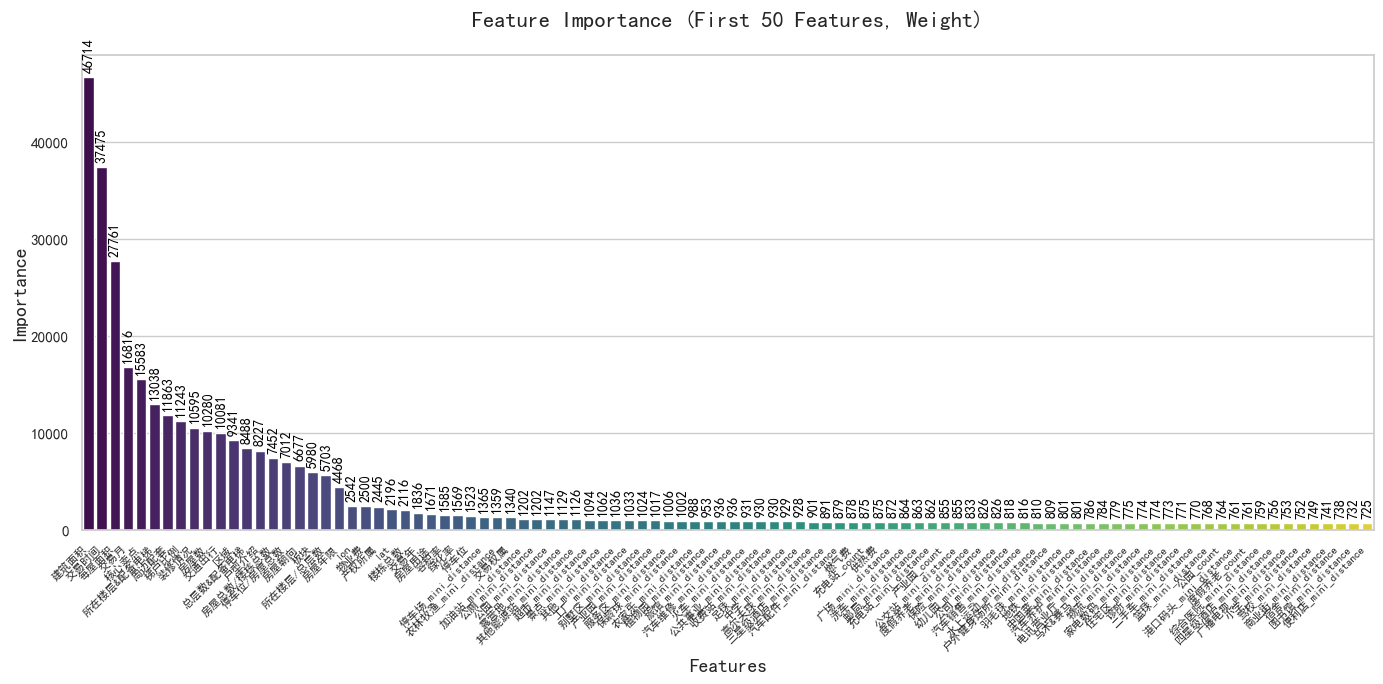

In [86]:
# 设置Seaborn样式，让图表更现代化
sns.set_theme(style="whitegrid")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 调整图表尺寸
plt.figure(figsize=(14, 7))  # 宽 14，高 7

# 可视化特征重要性（条形图）
ax = sns.barplot(
    data=importance_df.loc[:50],  # 只选前50个特征
    x="Feature", 
    y="Importance", 
    palette="viridis"  # 使用渐变配色
)

# 标题和轴标签
ax.set_title('Feature Importance (First 50 Features, Weight)', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)

# 调整x轴标签的字体大小、角度和对齐方式
plt.xticks(fontsize=8, rotation=45, ha='right')

# 添加数值标注（可选，标注每个柱状条的值）
for i in ax.containers:
    ax.bar_label(i, fmt="%.0f", fontsize=10, label_type='edge', padding=3, color='black', rotation=90)

# 添加紧凑布局以避免标签重叠
plt.tight_layout()

# 显示图表
plt.show()


In [87]:
# 获取特征重要性（使用 'gain' 方法）
importance = model.get_booster().get_score(importance_type='gain')  # 'weight', 'gain', 'cover'等

# 将特征重要性转为DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 打印重要性排序
print("Feature Importance:")
print(importance_df)

importance_df.to_csv('result\\feature_importance_gain.csv', index=False, encoding='utf-8-sig')

# 获取特征重要性（使用 'cover' 方法）
importance = model.get_booster().get_score(importance_type='gain')  # 'weight', 'gain', 'cover'等

# 将特征重要性转为DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 打印重要性排序
print("Feature Importance:")
print(importance_df)

importance_df.to_csv('result\\feature_importance_cover.csv', index=False, encoding='utf-8-sig')

Feature Importance:
               Feature    Importance
175          纪念馆_count  2.198571e+14
223          博物馆_count  1.065168e+14
149           剧场_count  9.139577e+13
141          别墅区_count  5.379644e+13
290  天文馆_mini_distance  4.952584e+13
..                 ...           ...
6                 交易时间  2.231561e+11
297         世界遗产_count  2.068864e+11
9                 交易权属  1.867946e+11
12                产权所属  1.832585e+11
8                  交易年  1.476339e+11

[306 rows x 2 columns]
Feature Importance:
               Feature    Importance
175          纪念馆_count  2.198571e+14
223          博物馆_count  1.065168e+14
149           剧场_count  9.139577e+13
141          别墅区_count  5.379644e+13
290  天文馆_mini_distance  4.952584e+13
..                 ...           ...
6                 交易时间  2.231561e+11
297         世界遗产_count  2.068864e+11
9                 交易权属  1.867946e+11
12                产权所属  1.832585e+11
8                  交易年  1.476339e+11

[306 rows x 2 columns]


In [88]:
# 使用sklearn的permutation_importance方法计算特征重要性
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# 将特征重要性转为DataFrame
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# 打印重要性排序
print("Feature Importance (Permutation Importance):")
print(importance_df)

# 保存特征重要性到CSV文件
importance_df.to_csv('result\\feature_importance_permutation.csv', index=False, encoding='utf-8-sig')

Feature Importance (Permutation Importance):
                Feature  Importance
2                  建筑面积    0.621170
300                 房屋数    0.039602
21                  物业费    0.038299
176           纪念馆_count    0.034166
228           充电站_count    0.023415
..                  ...         ...
83   小吃快餐_mini_distance   -0.000194
54           汽车维修_count   -0.000210
75   摄影打印_mini_distance   -0.000217
161   游乐场_mini_distance   -0.000244
14                 核心卖点   -0.000954

[307 rows x 2 columns]


C:\Users\86183\AppData\Local\Temp\ipykernel_49300\1380686548.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


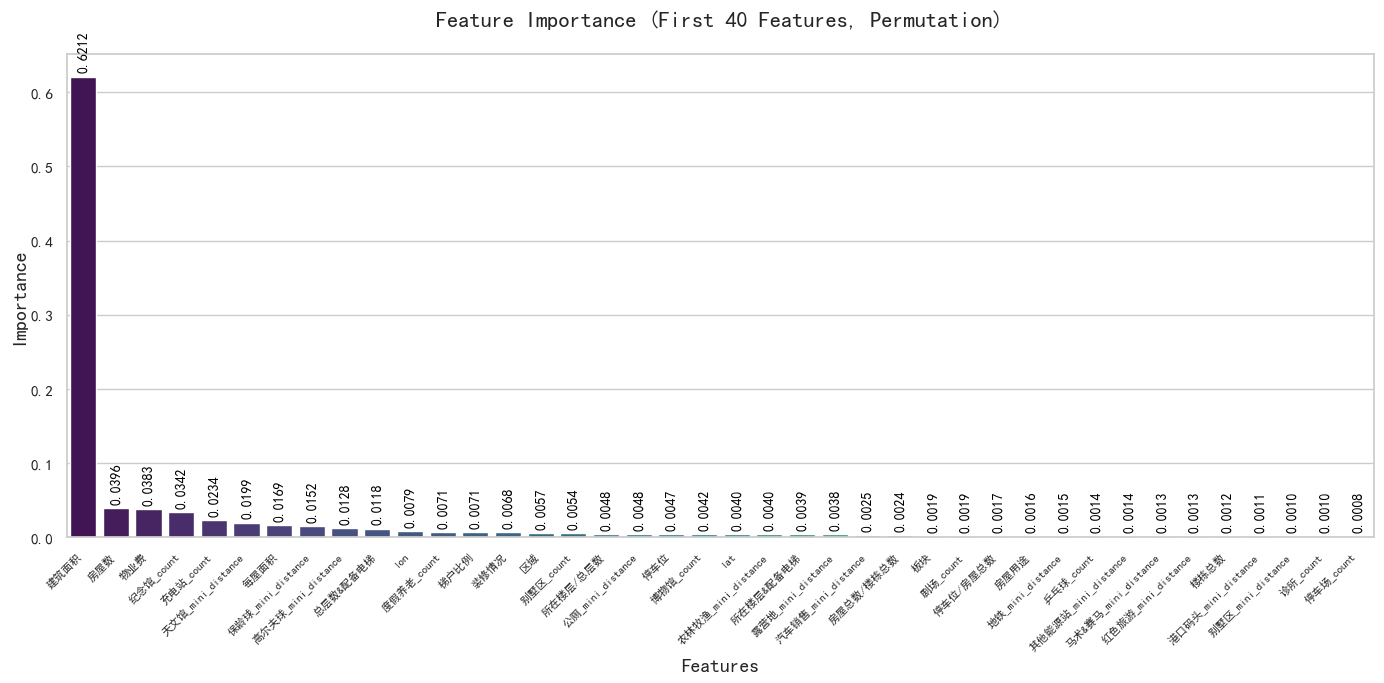

In [101]:
# 设置Seaborn样式，让图表更现代化
sns.set_theme(style="whitegrid")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 调整图表尺寸
plt.figure(figsize=(14, 7))  # 宽 14，高 7

# 可视化特征重要性（条形图）
ax = sns.barplot(
    data=importance_df.head(40),  # 只选前40个特征
    x="Feature", 
    y="Importance", 
    palette="viridis"  # 使用渐变配色
)

# 标题和轴标签
ax.set_title('Feature Importance (First 40 Features, Permutation)', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)

# 调整x轴标签的字体大小、角度和对齐方式
plt.xticks(fontsize=8, rotation=45, ha='right')

# 添加数值标注（可选，标注每个柱状条的值）
for i in ax.containers:
    ax.bar_label(i, fmt="%.4f", fontsize=10, label_type='edge', padding=3, color='black', rotation=90)

# 添加紧凑布局以避免标签重叠
plt.tight_layout()

# 显示图表
plt.show()


#### 2.2.2 贝叶斯参数优化

In [45]:
# 自定义目标函数
def objective(trial):
    # XGBoost 参数空间
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 5, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.04, log=True),
        'subsample': trial.suggest_float('subsample', 0.75, 0.85),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'gamma': trial.suggest_float('gamma', 0, 3),  # 控制是否后剪枝
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1)
        # ,
        # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
    }
    
    # 创建 XGBoost 模型
    model = xgb.XGBRegressor(**param)
    
    # 训练模型
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # 预测并评估性能
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse

# 通过 Optuna 进行贝叶斯优化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)  # 进行 2000 次试验

# 输出最佳参数
print(f"Best params: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

# 使用最佳参数训练模型
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# 评估模型性能
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"最终优化后的RMSE: {rmse}")

[I 2024-12-20 23:51:55,946] A new study created in memory with name: no-name-a8725218-755e-4a4c-af0a-96171ae285f4
[I 2024-12-20 23:52:11,843] Trial 0 finished with value: 380802.43287754664 and parameters: {'max_depth': 7, 'learning_rate': 0.023953760058718254, 'subsample': 0.8071143786593242, 'colsample_bytree': 0.8111014328206556, 'n_estimators': 300, 'gamma': 2.6055277626241287, 'lambda': 0.6518695739290945, 'alpha': 0.36353532248461184}. Best is trial 0 with value: 380802.43287754664.
[I 2024-12-20 23:52:48,621] Trial 1 finished with value: 372850.73819539894 and parameters: {'max_depth': 5, 'learning_rate': 0.035916194472213385, 'subsample': 0.8098191424098328, 'colsample_bytree': 0.8112780422959406, 'n_estimators': 1000, 'gamma': 2.9580831569383514, 'lambda': 0.24088235847909378, 'alpha': 0.768540729744786}. Best is trial 1 with value: 372850.73819539894.
[I 2024-12-20 23:53:05,883] Trial 2 finished with value: 361912.61382561683 and parameters: {'max_depth': 9, 'learning_rate': 

Best params: {'max_depth': 8, 'learning_rate': 0.033604559587444224, 'subsample': 0.8229950802521354, 'colsample_bytree': 0.8277642744573708, 'n_estimators': 1000, 'gamma': 2.154102528240927, 'lambda': 0.9477951230647754, 'alpha': 0.2899284273524977}
Best RMSE: 340030.52013254556
最终优化后的RMSE: 340030.52013254556


In [46]:
# 准备预测数据
X_pre = df_cleaned_pre.copy()
X_pre.drop(columns=['城市', '小区名称'], inplace=True)

X_pre = reset_X(X_pre)

# 将 X_pre 转换为 DMatrix 对象
dpre = xgb.DMatrix(X_pre)

# 使用原始数据进行预测
y_pred = best_model.predict(X_pre)

# 将预测结果保存到DataFrame
y_pre = pd.DataFrame(y_pred, columns=['Price'])
y_pre.reset_index(inplace=True)
y_pre.rename(columns={'index': 'ID'}, inplace=True)

# 将负值预测结果处理为500000
y_pre['Price'] = np.where(y_pre['Price'] < 0, 500000, y_pre['Price'])

# 保存预测结果到CSV文件
y_pre.to_csv('results\\xgboost_2.2.2_pre.csv', index=False)
print("预测结果已保存到 xgboost_2.2.2_pre.csv")


C:\Users\86183\AppData\Local\Temp\ipykernel_15312\264129173.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['每屋面积'].fillna(100, inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_15312\264129173.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

预测结果已保存到 xgboost_2.2.2_pre.csv


结果 81.71600

Best params: {'max_depth': 8, 'learning_rate': 0.033604559587444224, 'subsample': 0.8229950802521354, 'colsample_bytree': 0.8277642744573708, 'n_estimators': 1000, 'gamma': 2.154102528240927, 'lambda': 0.9477951230647754, 'alpha': 0.2899284273524977}


#### 2.2.3 贝叶斯优化 $\times$ 交叉验证

In [ ]:
# 自定义目标函数，使用交叉验证评估每一组超参数
def objective(trial):
    # 贝叶斯优化的参数空间
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 5, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.038, log=True),
        'subsample': trial.suggest_float('subsample', 0.75, 0.85),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'gamma': trial.suggest_float('gamma', 0, 3),  # 控制是否后剪枝
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1)
    }
    
    # 创建XGBoost模型
    model = XGBRegressor(**param)
    
    # 使用交叉验证（K折交叉验证）
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error', n_jobs=-1)
    
    # 返回平均的负RMSE作为优化目标（注意我们需要最小化RMSE，所以使用负值）
    rmse = -np.mean(scores)
    return rmse

# 通过Optuna进行贝叶斯优化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2500)  # 进行2500次试验

# 输出最佳参数
print(f"Best params from Optuna: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

# 使用最佳参数训练最终模型
best_params = study.best_params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# 在测试集上进行预测并评估
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"最终优化后的RMSE: {rmse}")

In [ ]:
# 准备预测数据
X_pre = df_cleaned_pre.copy()
X_pre.drop(columns=['城市', '小区名称'], inplace=True)

X_pre = reset_X(X_pre)

# 将 X_pre 转换为 DMatrix 对象
dpre = xgb.DMatrix(X_pre)

# 使用原始数据进行预测
y_pred = best_model.predict(X_pre)

# 将预测结果保存到DataFrame
y_pre = pd.DataFrame(y_pred, columns=['Price'])
y_pre.reset_index(inplace=True)
y_pre.rename(columns={'index': 'ID'}, inplace=True)

# 将负值预测结果处理为500000
y_pre['Price'] = np.where(y_pre['Price'] < 0, 500000, y_pre['Price'])

# 保存预测结果到CSV文件
y_pre.to_csv('results\\xgboost_2.2.3_pre.csv', index=False)
print("预测结果已保存到 xgboost_2.2.3_pre.csv")


C:\Users\86183\AppData\Local\Temp\ipykernel_15312\264129173.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['每屋面积'].fillna(100, inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_15312\264129173.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

预测结果已保存到 xgboost_2.2.2_pre.csv


Best params: {'max_depth': 6, 'learning_rate': 0.11516725243497607, 'subsample': 0.9018308795907305, 'colsample_bytree': 0.8787876718346751, 'n_estimators': 900, 'gamma': 2.0578643016599685, 'lambda': 0.3485288642804723, 'alpha': 0.5763081156833886, 'min_child_weight': 4, 'scale_pos_weight': 8.2869585595072, 'max_bin': 500}
Best RMSE: 443679.8919264281

得分79.96800

### 2.3 ANN 人工神经网络

In [102]:
X = df_cleaned.copy()
# print(X.columns)
X.drop(['价格','城市','小区名称'], axis=1, inplace=True)
y = df_cleaned['价格']
X = reset_X(X)


# 准备预测数据
X_pre = df_cleaned_pre.copy()
X_pre.drop(columns=['城市', '小区名称'], inplace=True)

X_pre = reset_X(X_pre)

# 标准化函数
def scale_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)  # 训练集标准化
    else:
        X_scaled = scaler.transform(X)  # 测试集和预测集标准化
    return X_scaled, scaler

print(X.isnull().sum())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# 标准化
X_train_scaled, scaler = scale_data(X_train)  # 标准化训练集
X_test_scaled, _ = scale_data(X_test, scaler)  # 使用训练集的 scaler 对测试集进行标准化
X_pre_scaled, _ = scale_data(X_pre, scaler)  # 使用训练集的 scaler 对预测数据进行标准化

C:\Users\86183\AppData\Local\Temp\ipykernel_49300\590346421.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['每屋面积'].fillna(100, inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_49300\590346421.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

区域           0
板块           0
建筑面积         0
房屋朝向         0
建筑结构         0
            ..
总层数&配备电梯     0
所在楼层&配备电梯    0
所在楼层/总层数     0
房屋总数/楼栋总数    0
停车位/房屋总数     0
Length: 307, dtype: int64


In [37]:
# 确保目标变量不具有太大的偏差（对数变换）
y_train_log = np.log1p(y_train)  # 取对数处理目标变量
y_test_log = np.log1p(y_test)  # 同样处理测试集

# 构建神经网络模型
model = Sequential()

# 第一层，加入BatchNormalization和Dropout
model.add(Dense(512, input_dim=X_train_scaled.shape[1], activation='gelu'))  # 第一个隐藏层，使用 GELU 激活函数
model.add(BatchNormalization())  # 添加批标准化层
model.add(Dropout(0.13))  # 添加Dropout层，防止过拟合

# 第二层
model.add(Dense(256, activation='gelu'))
model.add(BatchNormalization())  # 添加批标准化层
model.add(Dropout(0.13))  # 添加Dropout层

# 第三层（可选）
model.add(Dense(128, activation='gelu'))
model.add(BatchNormalization())  # 添加批标准化层
model.add(Dropout(0.13))  # 添加Dropout层

# 第四层
model.add(Dense(64, activation='gelu'))
model.add(BatchNormalization())  # 添加批标准化层
model.add(Dropout(0.13))  # 添加Dropout层

# 第五层
model.add(Dense(32, activation='gelu'))
model.add(BatchNormalization())  # 添加批标准化层
model.add(Dropout(0.13))  # 添加Dropout层

# 输出层，注意使用线性激活，因为目标是连续值
model.add(Dense(1))  # 输出层，预测房产价格

# 编译模型
optimizer = Adam(learning_rate=1e-5)  # 调整学习率
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', 'RootMeanSquaredError'])

# 使用早停法来防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 训练模型
history = model.fit(X_train_scaled, y_train_log, epochs=1000, batch_size=64, validation_data=(X_test_scaled, y_test_log), callbacks=[early_stopping])

# 评估模型
loss = model.evaluate(X_test_scaled, y_test_log)
print(f'Loss (MSE) on test set: {loss}')

# 预测并反转对数变换
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # 对数反变换，恢复到原始房产价格

# 输出一些预测结果
print("预测值:", y_pred[:5])
print("真实值:", np.expm1(y_test_log[:5]))  # 对数反变换的真实值

c:\Users\86183\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - RootMeanSquaredError: 14.1350 - loss: 199.8001 - mean_squared_error: 199.8001 - val_RootMeanSquaredError: 14.0578 - val_loss: 197.6208 - val_mean_squared_error: 197.6208
Epoch 2/1000
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - RootMeanSquaredError: 14.0101 - loss: 196.2832 - mean_squared_error: 196.2832 - val_RootMeanSquaredError: 13.8725 - val_loss: 192.4473 - val_mean_squared_error: 192.4473
Epoch 3/1000
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - RootMeanSquaredError: 13.8853 - loss: 192.8033 - mean_squared_error: 192.8033 - val_RootMeanSquaredError: 13.7676 - val_loss: 189.5474 - val_mean_squared_error: 189.5474
Epoch 4/1000
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - RootMeanSquaredError: 13.7640 - loss: 189.4483 - mean_squared_error: 189.4483 - val_RootMeanSquaredError: 13.6094 - val_loss: 185.2158 - val_mean_squared_error: 185.2158
Epoch 5/1000
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - RootMeanSquaredError: 13.6319 

In [ ]:
# 预测房产价格
y_pred_log = model.predict(X_pre_scaled)
y_pred = np.expm1(y_pred_log)  # 对数反变换，恢复到原始房产价格

# 将预测结果保存到DataFrame
y_pre = pd.DataFrame(y_pred, columns=['Price'])
y_pre.reset_index(inplace=True)
y_pre.rename(columns={'index': 'ID'}, inplace=True)

# 将负值预测结果处理为500000
y_pre['Price'] = np.where(y_pre['Price'] < 0, 500000, y_pre['Price'])

# 保存预测结果到CSV文件
y_pre.to_csv('results\\ann_2.3.1_pre.csv', index=False)
print("预测结果已保存到 ann_2.3.1_pre.csv")

### 2.4 改进后的Xgboost模型

#### 2.4.1 数据标准化和对数处理

In [4]:
X = df_cleaned.copy()
# print(X.columns)
X.drop(['价格','城市','小区名称'], axis=1, inplace=True)
y = df_cleaned['价格']
X = reset_X(X)


# 准备预测数据
X_pre = df_cleaned_pre.copy()
X_pre.drop(columns=['城市', '小区名称'], inplace=True)

X_pre = reset_X(X_pre)

# 标准化函数
def scale_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)  # 训练集标准化
    else:
        X_scaled = scaler.transform(X)  # 测试集和预测集标准化
    return X_scaled, scaler

print(X.isnull().sum())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# 标准化
X_train_scaled, scaler = scale_data(X_train)  # 标准化训练集
X_test_scaled, _ = scale_data(X_test, scaler)  # 使用训练集的 scaler 对测试集进行标准化
X_pre_scaled, _ = scale_data(X_pre, scaler)  # 使用训练集的 scaler 对预测数据进行标准化

# 确保目标变量不具有太大的偏差（对数变换）
y_train_log = np.log1p(y_train)  # 取对数处理目标变量
y_test_log = np.log1p(y_test)  # 同样处理测试集

C:\Users\86183\AppData\Local\Temp\ipykernel_36188\590346421.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['每屋面积'].fillna(100, inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_36188\590346421.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

区域           0
板块           0
建筑面积         0
房屋朝向         0
建筑结构         0
            ..
总层数&配备电梯     0
所在楼层&配备电梯    0
所在楼层/总层数     0
房屋总数/楼栋总数    0
停车位/房屋总数     0
Length: 307, dtype: int64


In [6]:
# 将标准化后的数据转换回DataFrame，并保持原始列名
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_pre_scaled_df = pd.DataFrame(X_pre_scaled, columns=X_pre.columns)

#### 2.4.2 模型训练

In [13]:
# 定义XGBoost训练的参数
params = {
    'objective': 'reg:squarederror',  # 回归问题，使用均方误差作为损失函数
    'max_depth': 7,  # 树的最大深度，控制模型的复杂度 7
    'eta': 0.01,  # 学习率，控制每次迭代更新的步长 0.023
    'subsample': 0.8,  # 训练时使用80%的样本，防止过拟合 0.8
    'colsample_bytree': 0.8  # 每棵树训练时，随机选择80%的特征 0.8
}

# 设置训练的最大迭代轮数和早停轮数
num_boost_round = 50000  # 最大训练轮数
early_stopping_rounds = 1000  # 如果在1000轮内验证集的误差没有改善，则提前停止训练

# 训练模型
xgb_model_scaled = XGBRegressor(**params, n_estimators=num_boost_round, early_stopping_rounds=early_stopping_rounds)
xgb_model_scaled.fit(X_train_scaled_df, y_train_log, eval_set=[(X_test_scaled_df, y_test_log)], verbose=True)

[0]	validation_0-rmse:0.64438
[1]	validation_0-rmse:0.63917
[2]	validation_0-rmse:0.63398
[3]	validation_0-rmse:0.62882
[4]	validation_0-rmse:0.62377
[5]	validation_0-rmse:0.61874
[6]	validation_0-rmse:0.61383
[7]	validation_0-rmse:0.60897
[8]	validation_0-rmse:0.60423
[9]	validation_0-rmse:0.59946
[10]	validation_0-rmse:0.59562
[11]	validation_0-rmse:0.59227
[12]	validation_0-rmse:0.58756
[13]	validation_0-rmse:0.58313
[14]	validation_0-rmse:0.57852
[15]	validation_0-rmse:0.57398
[16]	validation_0-rmse:0.56942
[17]	validation_0-rmse:0.56500
[18]	validation_0-rmse:0.56058
[19]	validation_0-rmse:0.55623
[20]	validation_0-rmse:0.55192
[21]	validation_0-rmse:0.54766
[22]	validation_0-rmse:0.54379
[23]	validation_0-rmse:0.53962
[24]	validation_0-rmse:0.53552
[25]	validation_0-rmse:0.53151
[26]	validation_0-rmse:0.52763
[27]	validation_0-rmse:0.52360
[28]	validation_0-rmse:0.51966
[29]	validation_0-rmse:0.51622
[30]	validation_0-rmse:0.51344
[31]	validation_0-rmse:0.50955
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=1000,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=None, num_parallel_tree=None, ...)

In [15]:
# 预测房产价格
y_pred_log = xgb_model_scaled.predict(X_pre_scaled)
y_pred = np.expm1(y_pred_log)  # 对数反变换，恢复到原始房产价格

# 将预测结果保存到DataFrame
y_pre = pd.DataFrame(y_pred, columns=['Price'])
y_pre.reset_index(inplace=True)
y_pre.rename(columns={'index': 'ID'}, inplace=True)

# 将负值预测结果处理为500000
y_pre['Price'] = np.where(y_pre['Price'] < 0, 500000, y_pre['Price'])

# 保存预测结果到CSV文件
y_pre.to_csv('result\\xgboost_2.4_pre.csv', index=False)
print("预测结果已保存到 ann_2.4_pre.csv")

预测结果已保存到 ann_2.4_pre.csv


#### 2.4.3 改进后的模型重要性排名

In [17]:
# 获取特征重要性（使用默认的 'weight' 方法）
importance = xgb_model_scaled.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover'等

# 将特征重要性转为DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 打印重要性排序
print("Feature Importance:")
print(importance_df)

importance_df.to_csv('result\\feature_importance_weight_improved.csv', index=False, encoding='utf-8-sig')

Feature Importance:
        Feature  Importance
2          建筑面积    114652.0
6          交易时间    110171.0
300        每屋面积     82521.0
7           交易月     46757.0
13         核心卖点     43981.0
..          ...         ...
293   保龄球_count        75.0
297  世界遗产_count        74.0
281  工业大楼_count        31.0
295    壁球_count        26.0
289   天文馆_count         7.0

[306 rows x 2 columns]


C:\Users\86183\AppData\Local\Temp\ipykernel_36188\561316291.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


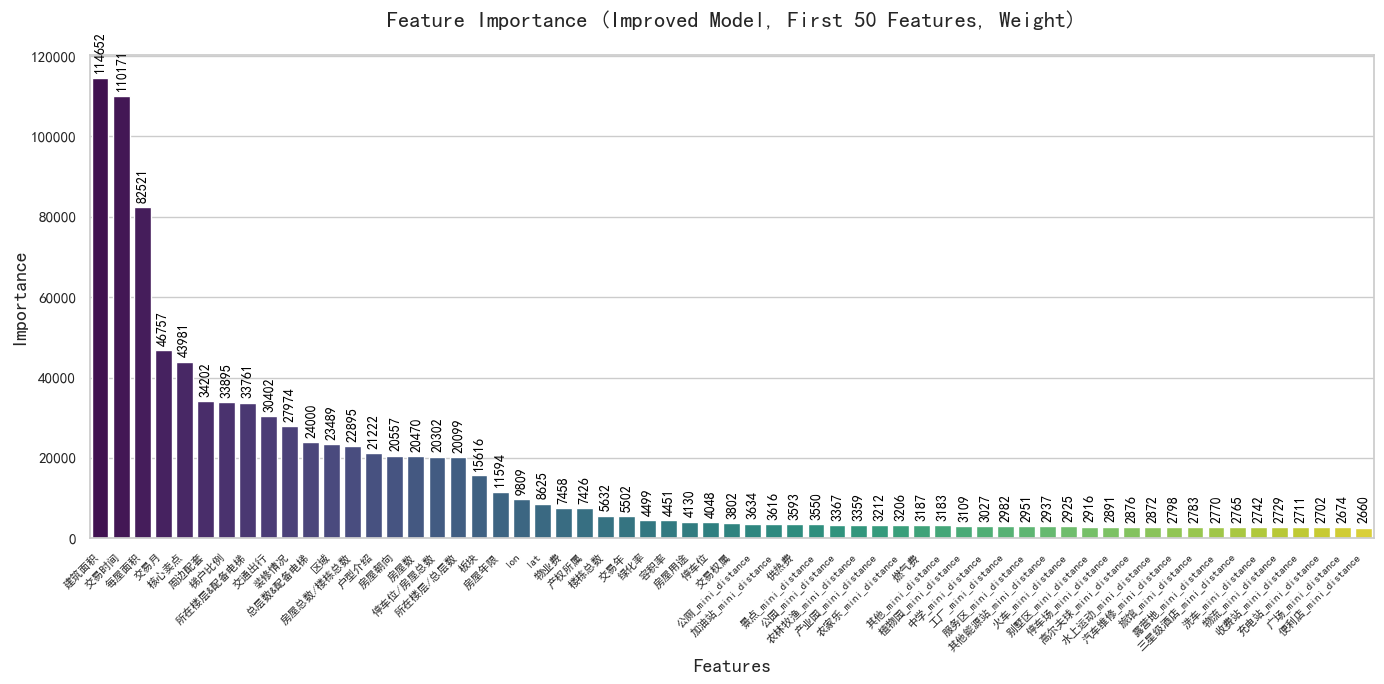

In [18]:
# 设置Seaborn样式，让图表更现代化
sns.set_theme(style="whitegrid")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 调整图表尺寸
plt.figure(figsize=(14, 7))  # 宽 14，高 7

# 可视化特征重要性（条形图）
ax = sns.barplot(
    data=importance_df.loc[:50],  # 只选前50个特征
    x="Feature", 
    y="Importance", 
    palette="viridis"  # 使用渐变配色
)

# 标题和轴标签
ax.set_title('Feature Importance (Improved Model, First 50 Features, Weight)', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)

# 调整x轴标签的字体大小、角度和对齐方式
plt.xticks(fontsize=8, rotation=45, ha='right')

# 添加数值标注（可选，标注每个柱状条的值）
for i in ax.containers:
    ax.bar_label(i, fmt="%.0f", fontsize=10, label_type='edge', padding=3, color='black', rotation=90)

# 添加紧凑布局以避免标签重叠
plt.tight_layout()

# 显示图表
plt.show()


In [20]:
# 使用sklearn的permutation_importance方法计算特征重要性
perm_importance = permutation_importance(xgb_model_scaled, X_test_scaled_df, y_test_log, n_repeats=5, random_state=42)

# 将特征重要性转为DataFrame
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# 打印重要性排序
print("Feature Importance (Permutation Importance):")
print(importance_df)

# 保存特征重要性到CSV文件
importance_df.to_csv('result\\feature_importance_permutation_improved.csv', index=False, encoding='utf-8-sig')

Feature Importance (Permutation Importance):
               Feature    Importance
2                 建筑面积  6.356883e-01
295  保龄球_mini_distance  1.242682e-01
21                 物业费  3.666092e-02
228          充电站_count  2.580808e-02
291  天文馆_mini_distance  2.515750e-02
..                 ...           ...
136         疾病预防_count -5.501910e-07
104          农家乐_count -1.693284e-06
116         彩票销售_count -5.110154e-06
232         美术展览_count -1.900164e-05
9                  交易年 -4.146341e-05

[307 rows x 2 columns]


C:\Users\86183\AppData\Local\Temp\ipykernel_36188\3808512488.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


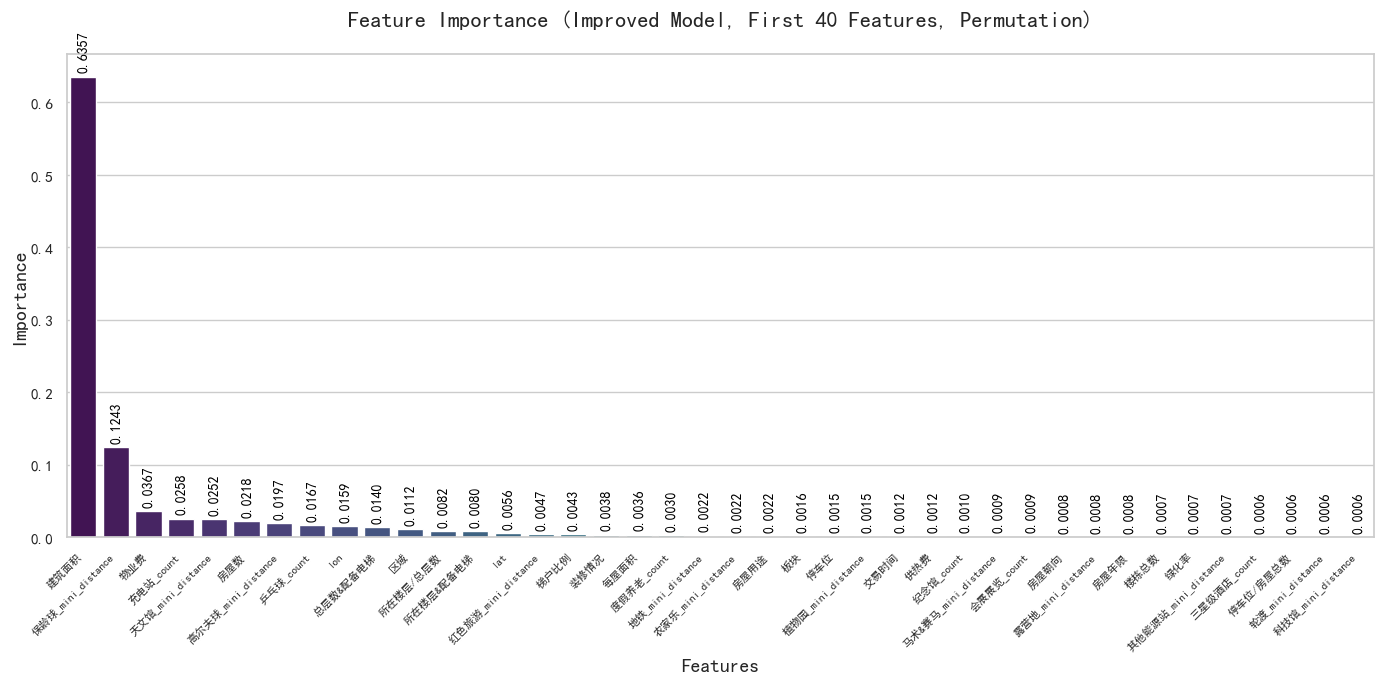

In [21]:
# 设置Seaborn样式，让图表更现代化
sns.set_theme(style="whitegrid")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 调整图表尺寸
plt.figure(figsize=(14, 7))  # 宽 14，高 7

# 可视化特征重要性（条形图）
ax = sns.barplot(
    data=importance_df.head(40),  # 只选前40个特征
    x="Feature", 
    y="Importance", 
    palette="viridis"  # 使用渐变配色
)

# 标题和轴标签
ax.set_title('Feature Importance (Improved Model, First 40 Features, Permutation)', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)

# 调整x轴标签的字体大小、角度和对齐方式
plt.xticks(fontsize=8, rotation=45, ha='right')

# 添加数值标注（可选，标注每个柱状条的值）
for i in ax.containers:
    ax.bar_label(i, fmt="%.4f", fontsize=10, label_type='edge', padding=3, color='black', rotation=90)

# 添加紧凑布局以避免标签重叠
plt.tight_layout()

# 显示图表
plt.show()


## 3 附录

### 3.1 Xgboost参数总结

| 参数名                | 简单说明                     | 范围          | 默认   | 典型值       | rank | 说明                                                                                  |
|-----------------------|----------------------------|---------------|--------|--------------|------|--------------------------------------------------------------------------------------|
| n_estimators          | 学习器的数量                | int           | 100    | 100~500      | 3    | 基本学习器的数量                                                                      |
| max_depth             | 树深度                     | 0,∞           | 3      | 3~10         | 3    | 每个基本学习器树的最大深度，值越大数越复杂                                            |
| learning_rate         | 学习率                     | [0，1]        | 0.1    | 0.01~0.2     | 3    | 每次迭代更新权重时的步长。值越小，训练的越慢。                                        |
| gamma                 | 损失减少阈值                | 0,∞           | 0      | None         | 3    | 分裂节点时，损失函数减小值只有大于等于gamma节点才分裂，gamma值越大，算法越保守        |
| reg_alpha             | L1正则化                   | float         | 0      | None         | 3    | 增加该值会让模型更加收敛                                                              |
| reg_lambda            | L2正则化                   | float         | 1      | None         | 3    | 控制XGBoost的正则化部分的，可以减少过拟合                                             |
| min_child_weight      | 子集最小权重                | 0,∞           | 1      | None         | 3    | 如果节点的样本权重和小于该阈值，就不再进行拆分，该指数越大越大算法越保守。            |
| subsample             | 样本子采样                 | (0,1]         | 1      | 0.5-0.9      | 3    | 随机选取一定比例的样本来训练树。设置为0.5，则意味着XGBoost将从整个样本集合中随机抽取50%子样本建立树模型 |
| colsample_bytree      | 列子采样                   | (0,1]         | 1      | 0.5-0.9      | 3    | 列采样率，也就是特征采样率。在建立树时对特征采样的比例                                |
| booster               | 基模型类型                  | gbtree, gblinear | gbtree | None         | 2    | gbtree使用基于树的模型进行提升计算，gblinear使用线性模型进行提升计算                  |
| colsample_bylevel     | 列子采样                   | (0,1]         | 1      | None         | 2    | 构建每一层时，列采样率                                                                |
| colsample_bynode      | 列子采样                   | [0,1]         | 1      | None         | 2    | 是每个节点（拆分）的列的子采样率                                                     |
| scale_pos_weight      | 处理样本不平衡              | float         | 1      | None         | 2    | 处理样本不平衡问题。在样本高度不平衡时，将参数设置大于0，可以加快算法收敛。           |
| random_state          | 随机数种子                  | int           | 0      | None         | 2    | 设置它可以复现随机数据的结果，也可以用于调整参数                                       |
| max_delta_step        | 树权重最大增量              | 0,∞           | 0      | 0~10         | 1    | 每棵树所被允许的权重估计为最大增量。如果该值设置为0，则表示没有约束。通常不需要这个参数，但当类极不平衡时，它可能有助于logistic回归 |
| verbosity             | 日志长度                   | int           |        | None         | 1    | 日志冗长程度0-3                                                                        |
| tree_method           | 指定树方法                  | auto, exact, approx, hist, gpu_exact, gpu_hist | auto | None | 1 | 指定要使用的树生成算法 |
| base_score            | 全局偏差                   | int/float     | 0.5    |              | 1    | 所有实例的初始预测得分，整体偏倚                                                      |
| silent                | 过程打印设置                | 0,1 or True,False | 0  | None         | 1    | 取0时表示打印出运行时信息，取1时表示不打印运行时信息                                  |
| importance_type       | 特征重要性类型              | None          |        | None         | 1    | feature_importances_属性的特征重要性类型                                              |
| eval_metric           | 指定评估指标                | rmse, mae, logloss, error, merror, mlogloss, auc | 回归:rmse 分类:error | 回归:rmse 分类:error | 1 | 校验数据所需要的评价指标，不同的目标函数将会有缺省的评价指标    |
| missing               | 缺失值                     | None          |        | None         | 0    | 需要作为缺失值存在的数据中的值,如果为none，则默认为np.nan                             |
| num_parallel_tree     | 增强随机森林                | int           |        | None         | 0    | 用于增强随机森林                                                                       |
| kwargs                | 字典形式传参                | dict          |        | None         | 0    | 以字典形式传递参数                                                                    |
| n_jobs                | 线程数目                    | int           | 1      | None         | 0    | 线程数目                                                                               |
| nthread               | 并行计算设置                | int           | 默认当前系统可以获得的最大线程数 | None | 0 | XGBoost运行时的线程数                                          |
| monotone_constraints  | 变量单调性约束              | None          |        | None         | 0    | 变量单调性约束                                                                         |
| interaction_constraints | 交互约束                 | None          |        | None         | 0    | 表示允许交互的交互约束                                                                 |
| gpu_id                | gpu ID                     | None          |        | None         | 0    | 无                                                                                     |
| validate_parameters   | 验证参数                    | None          |        | None         | 0    | 无                                                                                     |
| objective             | 指定损失函数                | reg:linear, reg:logistic, binary:logistic, binary:logitraw, count:poisson, multi:softmax, multi:softprob, rank:pairwise |       | None         | 0    | 指的是需要被最小化的损失函数  |


### 3.2 一些绘图

In [12]:


# 储存一下原始的y值
y0=y

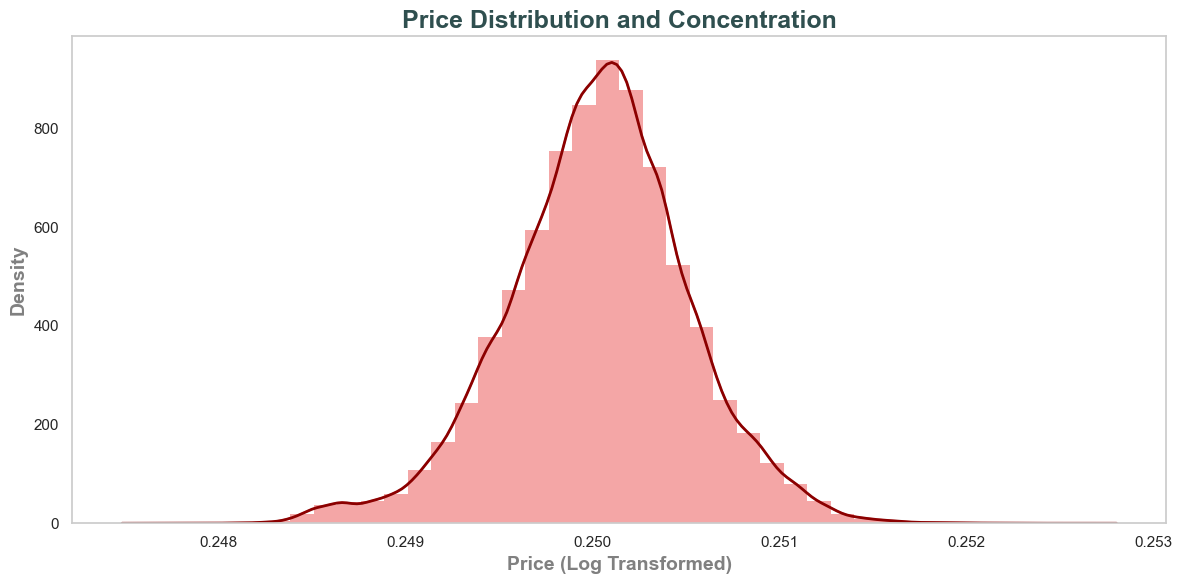

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False  # 防止负号显示问题

y = np.log1p(y)  # 对价格进行对数变换

# 设置 Seaborn 风格
sns.set(style="whitegrid")

# 创建图形
plt.figure(figsize=(12, 6))

# 使用带有 KDE（核密度估计）的直方图，显示价格数据的分布
sns.histplot(y, kde=True, color="lightcoral", bins=40, stat="density", linewidth=0, alpha=0.7)

# 在直方图上绘制平滑的 KDE 曲线，进一步展示数据的分布情况
sns.kdeplot(y, color='darkred', linewidth=2)

# 添加标题和标签（英文表述）
plt.title("Price Distribution and Concentration", fontsize=18, weight='bold', color='darkslategray')  # 图表标题
plt.xlabel("Price (Log Transformed)", fontsize=14, weight='bold', color='gray')  # x 轴标签
plt.ylabel("Density", fontsize=14, weight='bold', color='gray')  # y 轴标签

# 移除网格线，使图表看起来更加清晰
plt.grid(False)

# 显示图形
plt.tight_layout()
plt.show()


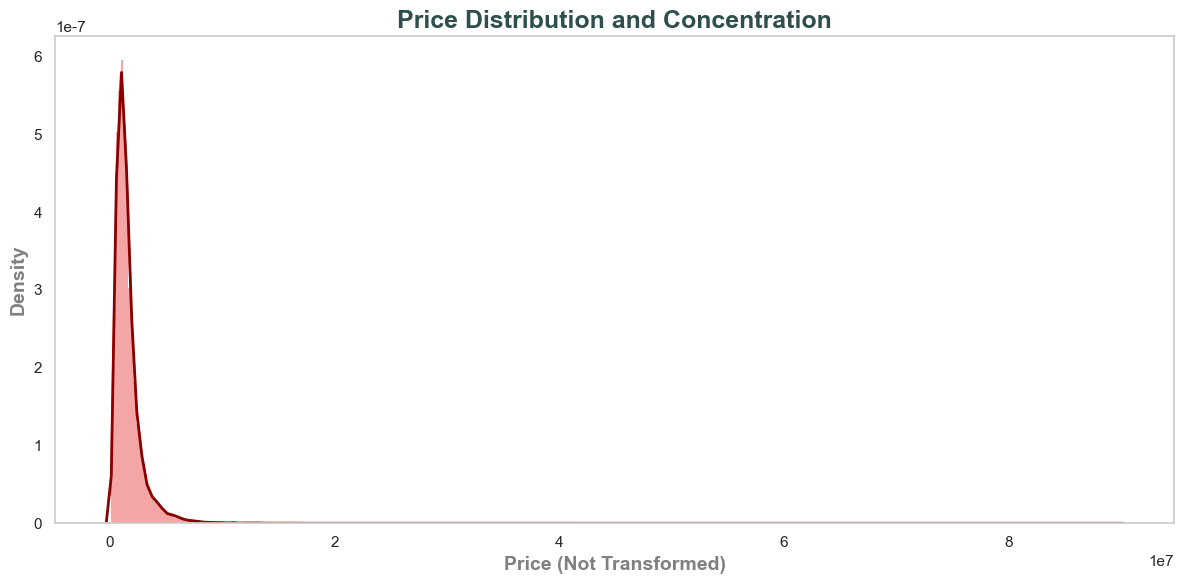

In [28]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False  # 防止负号显示问题

y = y0

# 设置 Seaborn 风格
sns.set(style="whitegrid")

# 创建图形
plt.figure(figsize=(12, 6))

# 使用带有 KDE（核密度估计）的直方图，显示价格数据的分布
sns.histplot(y, kde=True, color="lightcoral", bins=400, stat="density", linewidth=0, alpha=0.7)

# 在直方图上绘制平滑的 KDE 曲线，进一步展示数据的分布情况
sns.kdeplot(y, color='darkred', linewidth=2)

# 添加标题和标签（英文表述）
plt.title("Price Distribution and Concentration", fontsize=18, weight='bold', color='darkslategray')  # 图表标题
plt.xlabel("Price (Not Transformed)", fontsize=14, weight='bold', color='gray')  # x 轴标签
plt.ylabel("Density", fontsize=14, weight='bold', color='gray')  # y 轴标签

# 移除网格线，使图表看起来更加清晰
plt.grid(False)

# 显示图形
plt.tight_layout()
plt.show()